In [ ]:
!pip install --quiet open_atmos_jupyter_utils

In [1]:
import os
os.environ['NUMBA_THREADING_LAYER'] = 'omp'

import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

# Brzegowa fala Kelvina w przybliżeniu płytkiej wody

**Autor:** Piotr Mróz  
**Data:** 3 grudnia 2025


## Cel projektu

Celem niniejszej symulacji jest numeryczne zbadanie propagacji
brzegowej fali Kelvina w przybliżeniu równania płytkiej wody
na prostokątnym obszarze basenu oceanicznego.

W szczególności chcemy odpowiedzieć na pytanie:

> Czy korzystając z równań dynamiki płynu w przybliżeniu
> "płytkiej wody" można numerycznie odtworzyć brzegową falę Kelvina,
> oraz jak rozdzielczość siatki numerycznej (względem promienia
> deformacji Rossby’ego) wpływa na prędkość propagacji fali
> wzdłuż brzegu oraz szerokość poprzeczną fali?


## Użyte równania

W modelu płytkiej wody rozpatrujemy równania

$$
\begin{aligned}
\frac{\partial h}{\partial t}
+ \frac{\partial (hu)}{\partial x}
+ \frac{\partial (hv)}{\partial y} = 0, \\
\frac{\partial (hu)}{\partial t}
+ \frac{\partial}{\partial x}
\left(hu^2 + \frac{1}{2} g h^2 \right)
+ \frac{\partial (huv)}{\partial y}
- f hv = 0, \\
\frac{\partial (hv)}{\partial t}
+ \frac{\partial (huv)}{\partial x}
+ \frac{\partial}{\partial y}
\left(hv^2 + \frac{1}{2} g h^2 \right)
+ f hu = 0,
\end{aligned}
$$

gdzie $h(x,y,t)$ jest wysokością słupa cieczy,
$\mathbf{u} = (u,v)$ jest poziomym polem prędkości,
$g$ – przyspieszeniem grawitacyjnym,
a $f$ – parametrem Coriolisa.


## Warunki brzegowe i początkowe

Rozpatrujemy prostokątny basen o wymiarach $L_x,\times L_y,$ z brzegiem wzdłuż $x = 0$. Wykorzystujemy:

- **warunki brzegowe**:
  - sztywny brzeg wzdłuż $x = 0$:
$$
  u(x=0,y,t) = 0,
$$
  - brzegi wzdłuż osi $y$: periodyczne warunki brzegowe
  - brzeg wzdłuż osi $x$ "w głębi oceanu": wygaszanie fali, tzw. "gąbka"

- **warunek początkowy** dla wysokości:
  lokalna „górka” przy brzegu,
  $$
  \eta(x,y,0)
  = A \exp\left(
    - \frac{(x-x_0)^2}{2\sigma_x^2}
    - \frac{(y-y_0)^2}{2\sigma_y^2}
  \right),
  $$
  gdzie $A$ jest amplitudą zaburzenia.


## Parametry numeryczne

W symulacji wykorzystano jednorodną siatkę numeryczną:

$$\Delta x = \Delta y,$$


oraz krok czasowy $\Delta t$ dobrany tak, aby spełnić warunek CFL.

Przyjmujemy:

- stałą głębokość tła H = $\text{200 m}$,
- szerokość geograficzną $\varphi = 80^\circ$,
  więc
$$
  f = 2 \Omega \sin\varphi,
  \quad
  c = \sqrt{gH},
  \quad
  L_R = \frac{c}{f},
$$
  gdzie $L_R$ jest promieniem deformacji Rossby'ego,


Dla analiz wpływu rozdzielczości siatki względem promienia
deformacji Rossby'ego $R_d$ wykorzystano kilka konfiguracji:

$$
\frac{\Delta x}{R_d} \in \{ \alpha_1,\ \alpha_2,\ \alpha_3, \dots \}.
$$

Dla każdej z nich wyznaczono prędkość propagacji fali wzdłuż brzegu
oraz efektywną szerokość poprzeczną fali.


In [2]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """

        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': (boundary_conditions.Constant(value=0), boundary_conditions.Periodic()),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'], axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int,
                 g: float,
                 dt_over_dxy: tuple,
                 outfreq: int,
                 eps: float=1e-7,
                 f_cor: float=0.0,
                 sponge_width: int,
                 sigma_max: float,
                 dt: float): # dodano parametr Coriolisa
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        f_times_dt = f_cor * dt  # assuming dt_over_dxy[0] == dt_over_dxy[1]
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key,
                                                mask=mask, dt_over_dxy=dt_over_dxy)

                self.solvers["h"].advance(n_steps=1)

                # --- momenta ---
                for axis, key in enumerate(("uh", "vh")):
                    # ciśnienie
                    self._apply_half_rhs(key=key, axis=axis,
                                        g_times_dt_over_dxy=g * dt_over_dxy[axis])

                # Coriolis – pierwszy półkrok (wspólny dla obu składowych)
                if f_cor != 0.0:
                    self._apply_coriolis_half_step(f_times_dt=f_times_dt, eps=eps)

                for axis, key in enumerate(("uh", "vh")):
                    self.solvers[key].advance(n_steps=1)

                # Coriolis – drugi półkrok
                if f_cor != 0.0:
                    self._apply_coriolis_half_step(f_times_dt=f_times_dt, eps=eps)

                # dokończenie ciśnienia
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis,
                                        g_times_dt_over_dxy=g * dt_over_dxy[axis])

                self['uh'][0, :] = 0.0   # brak przepływu przez brzeg x=0

                H = float(np.mean(self['h']))  # przybliżona głębokość tła

                self._apply_sponge_layer(dt=dt, H=H,
                            sponge_width=sponge_width,
                            sigma_max=sigma_max)



            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

    def _apply_coriolis_half_step(self, f_times_dt: float, eps: float):
        h = self['h']
        uh = self['uh']
        vh = self['vh']

        # przelicz pędy na prędkości tam gdzie jest woda
        u = np.zeros_like(h)
        v = np.zeros_like(h)
        mask = h > eps
        np.divide(uh, h, where=mask, out=u)
        np.divide(vh, h, where=mask, out=v)

        # człony: d(uh)/dt =  f * h * v
        #        d(vh)/dt = -f * h * u
        uh[:] += 0.5 * f_times_dt * h * v
        vh[:] -= 0.5 * f_times_dt * h * u
    def _apply_sponge_layer(self, dt: float, H: float,
                            sponge_width: int,
                            sigma_max: float):
        """
        Prosta warstwa wygaszająca przy dużym x:
        - w ostatnich 'sponge_width' kolumnach ściąga h -> H, uh -> 0, vh -> 0.
        - sigma(x) rośnie gładko od 0 do sigma_max.
        """
        h = self['h']
        uh = self['uh']
        vh = self['vh']

        nx, ny = h.shape
        x_start = max(0, nx - sponge_width)

        for i in range(x_start, nx):
            # i = x_start ... nx-1
            # normalizowany indeks od 0 do 1
            s = (i - x_start) / max(1, nx - 1 - x_start)
            # gładka funkcja od 0 do sigma_max (np. kwadratowa)
            sigma = sigma_max * s**2

            # czynnik tłumienia na jeden krok (ważne: sigma * dt << 1)
            factor = 1.0 - sigma * dt

            # tłumimy odchylenie od tła
            h[i, :] = H + (h[i, :] - H) * factor
            uh[i, :] *= factor
            vh[i, :] *= factor


In [3]:
g = 9.81
H_val = 200.0
Omega = 2 * np.pi / 86164
phi_deg = 80.0
phi_rad = np.deg2rad(phi_deg)
f_cor = 2 * Omega * np.sin(phi_rad)

c = np.sqrt(g * H_val)  # prędkość Kelvina

def run_kelvin_sim(
    nx: int,
    ny: int,
    dx: float,
    dy: float,
    CFL: float = 0.4,
    nt: int = 1000,
    outfreq: int = 10,
    sponge_width: int = 10,
    sigma_max: float = 2e-3,
    A: float = 0.1,
):
    """
    Uruchamia jedną symulację Kelvina dla zadanej siatki i parametrów czasowych.

    Zwraca słownik z:
      - output: surowe dane z integratora (listy snapshotów 'h', 'uh', 'vh')
      - x, y, dx, dy
      - dt, times, outfreq
      - y0_index: indeks wzdłuż brzegu, gdzie była początkowo paczka
    """
    # krok czasowy z CFL
    dt = CFL * dx / c
    dt_over_dxy = (dt / dx, dt / dy)

    # siatka fizyczna
    x = np.arange(nx) * dx
    y = np.arange(ny) * dy
    X, Y = np.meshgrid(x, y, indexing="ij")

    # warunek początkowy – jak u Ciebie, tylko parametryzowany
    x_c = 0.85 * nx * dx          # środek paczki w oceanie
    Lx = 0.05 * nx * dx           # szerokość w x
    y0 = 0.5 * ny * dy            # środek wzdłuż brzegu
    Ly = 0.2 * ny * dy            # szerokość w y

    envelopex = np.exp(-((X - x_c) ** 2) / (2 * Lx ** 2))
    envelopey = np.exp(-((Y - y0) ** 2) / (2 * Ly ** 2))
    eta0 = A * envelopex * envelopey

    h_initial = H_val + eta0

    # integrator MPDATA
    integrator = ShallowWaterEquationsIntegrator(h_initial=h_initial)

    output = integrator(
        nt=nt,
        g=g,
        dt_over_dxy=dt_over_dxy,
        outfreq=outfreq,
        f_cor=f_cor,
        sigma_max=sigma_max,
        sponge_width=sponge_width,
        dt=dt,
    )

    n_snaps = len(output["h"])
    times = np.arange(n_snaps) * outfreq * dt

    y0_index = int(y0 / dy)

    return {
        "output": output,
        "x": x,
        "y": y,
        "dx": dx,
        "dy": dy,
        "dt": dt,
        "times": times,
        "outfreq": outfreq,
        "y0_index": y0_index,
    }


In [4]:
def compute_kelvin_speed(h_series, H: float, dt: float, outfreq: int, dy: float,
                         n_coastal: int = 4,
                         t_fit_fraction=(0.2, 0.8)):
    """
    Szacuje prędkość Kelvina na podstawie wędrówki maksimum fali wzdłuż brzegu.

    h_series : lista/array snapshotów h[t, x, y]
    H        : głębokość tła
    dt       : krok czasowy
    outfreq  : co ile kroków zapisywany jest stan
    dy       : rozdzielczość w y
    n_coastal: ile komórek od brzegu (x=0) traktujemy jako „pas przybrzeżny”
    t_fit_fraction: ułamek czasu [t0, t1], na którym dopasowujemy prostą
    """
    h_arr = np.asarray(h_series)          # [nt_snap, nx, ny]
    eta = h_arr - H
    n_snaps, nx, ny = eta.shape

    times = np.arange(n_snaps) * outfreq * dt

    # pozycja „środka masy” amplitudy wzdłuż brzegu
    y_pos = np.zeros(n_snaps)
    y_coords = np.arange(ny) * dy

    for it in range(n_snaps):
        stripe = eta[it, 0:n_coastal, :]       # pas przybrzeżny
        A_y = np.max(stripe, axis=0)          # koperta po x
        A_y = np.maximum(A_y, 0.0)

        if A_y.sum() == 0.0:
            y_pos[it] = np.nan
        else:
            y_pos[it] = np.sum(A_y * y_coords) / np.sum(A_y)

    # wybór przedziału czasowego do dopasowania prędkości
    t0 = times[0] + t_fit_fraction[0] * (times[-1] - times[0])
    t1 = times[0] + t_fit_fraction[1] * (times[-1] - times[0])
    mask = (times >= t0) & (times <= t1) & np.isfinite(y_pos)

    coeffs = np.polyfit(times[mask], y_pos[mask], 1)
    speed = coeffs[0]  # [m/s]

    return speed, times, y_pos


In [5]:
def compute_cross_shore_width(h_series, H: float, dx: float,
                              y_index: int,
                              snapshot_index: int | None = None):
    """
    Szacuje szerokość poprzeczną fali z przekroju h(x, y_index) w wybranym czasie.

    Zwraca sigma [m], którą możesz porównać z promieniem Rossby'ego.
    """
    h_arr = np.asarray(h_series)  # [nt_snap, nx, ny]

    if snapshot_index is None:
        snapshot_index = h_arr.shape[0] // 2  # środek symulacji

    eta_profile = h_arr[snapshot_index, :, y_index] - H
    eta_profile = np.maximum(eta_profile, 0.0)

    if eta_profile.sum() == 0.0:
        return np.nan

    x = np.arange(eta_profile.size) * dx
    w = eta_profile / eta_profile.sum()
    x_mean = np.sum(w * x)
    var = np.sum(w * (x - x_mean)**2)
    sigma = np.sqrt(var)  # efektywny „promień”
    return sigma


In [6]:
from mpl_toolkits.mplot3d import Axes3D  # niekonieczne w nowych wersjach, ale nie szkodzi

def plot_kelvin_fields(sim: dict,
                       snapshot_index: int = -1,
                       label: str = "",
                       downsample: int = 8,
                       save_prefix: str | None = None,
                       make_animation: bool = False,
                       gif_file: str = "anim.gif",
                       make_hovmoller: bool = True):
    """
    Rysuje:
      - 2D mapę anomalii poziomu morza,
      - pole wektorowe prędkości (u, v),
      - przekrój poprzeczny (x) w okolicy y0,
      - przekrój wzdłuż brzegu (y) przy brzegu (x~0),
      - opcjonalnie: 3D wireframe + GIF (make_animation),
      - opcjonalnie: diagram Hovmöllera przy x=0 (make_hovmoller).

    Wszystkie zapisywane rysunki zapisujemy jako PDF (grafika wektorowa),
    GIF jest rasterem, ale tylko dla animacji.
    """
    out = sim["output"]
    x = sim["x"]
    y = sim["y"]
    dx = sim["dx"]
    dy = sim["dy"]
    times = sim["times"]
    y0_index = sim["y0_index"]

    # --- snapshot do statycznych rysunków ---
    h_snap = np.asarray(out["h"][snapshot_index])
    uh_snap = np.asarray(out["uh"][snapshot_index])
    vh_snap = np.asarray(out["vh"][snapshot_index])

    eta_snap = h_snap - H_val

    # prędkości
    u_snap = np.zeros_like(h_snap)
    v_snap = np.zeros_like(h_snap)
    mask_snap = h_snap > 1e-7
    u_snap[mask_snap] = uh_snap[mask_snap] / h_snap[mask_snap]
    v_snap[mask_snap] = vh_snap[mask_snap] / h_snap[mask_snap]

    Xkm, Ykm = np.meshgrid(x / 1e3, y / 1e3, indexing="ij")
    time_days = times[snapshot_index] / 86400.0

    # 1) mapa 2D anomalii poziomu morza
    fig1, ax1 = plt.subplots(figsize=(7, 3))
    pcm = ax1.pcolormesh(Ykm, Xkm, eta_snap, shading="auto")
    cb = fig1.colorbar(pcm, ax=ax1, label=r"$\eta\ \mathrm{[m]}$")
    ax1.set_xlabel(r"$y\ \mathrm{[km]}$")
    ax1.set_ylabel(r"$x\ \mathrm{[km]}$")
    ax1.set_title(rf"Anomalia poziomu morza, $t={time_days:.1f}$ dni ({label})")
    fig1.tight_layout()
    if save_prefix is not None:
        fig1.savefig(f"{save_prefix}_eta2D.pdf")
    plt.show()

    # 2) pole wektorowe prędkości (quiver) – przetrzebione
    stride_x = max(1, h_snap.shape[0] // (downsample * 8))
    stride_y = max(1, h_snap.shape[1] // (downsample * 16))

    fig2, ax2 = plt.subplots(figsize=(7, 3))
    ax2.quiver(
        Ykm[::stride_x, ::stride_y],
        Xkm[::stride_x, ::stride_y],
        v_snap[::stride_x, ::stride_y],
        u_snap[::stride_x, ::stride_y],
        scale=None,
    )
    ax2.set_xlabel(r"$y\ \mathrm{[km]}$")
    ax2.set_ylabel(r"$x\ \mathrm{[km]}$")
    ax2.set_title(rf"Pole prędkości, $t={time_days:.1f}$ dni ({label})")
    fig2.tight_layout()
    if save_prefix is not None:
        fig2.savefig(f"{save_prefix}_uv_quiver.pdf")
    plt.show()

    # 3) przekrój poprzeczny (x) w okolicy y0
    x_km = x / 1e3
    fig3, ax3 = plt.subplots(figsize=(6, 3))
    ax3.plot(x_km, eta_snap[:, y0_index])
    ax3.set_xlabel(r"$x\ \mathrm{[km]}$")
    ax3.set_ylabel(r"$\eta\ \mathrm{[m]}$")
    ax3.set_title(rf"Przekrój poprzeczny przy $y \approx y_0$, $t={time_days:.1f}$ dni")
    fig3.tight_layout()
    if save_prefix is not None:
        fig3.savefig(f"{save_prefix}_section_x.pdf")
    #plt.show()

    # 4) przekrój wzdłuż brzegu (y) przy brzegu (x=0)
    fig4, ax4 = plt.subplots(figsize=(6, 3))
    ax4.plot(y / 1e3, eta_snap[0, :])
    ax4.set_xlabel(r"$y\ \mathrm{[km]}$")
    ax4.set_ylabel(r"$\eta\ \mathrm{[m]}$")
    ax4.set_title(rf"Przekrój wzdłuż brzegu (x=0), $t={time_days:.1f}$ dni")
    fig4.tight_layout()
    if save_prefix is not None:
        fig4.savefig(f"{save_prefix}_section_y.pdf")
    #plt.show()

    # --- 5) animacja 3D wireframe + GIF ---
    if make_animation:
        h_all = np.asarray(out["h"])  # [nt_snap, nx, ny]
        nt_snap, nx_snap, ny_snap = h_all.shape

        def plot(frame, *, zlim=(0.999 * H_val, 1.001 * H_val)):
            psi = h_all[frame]
            xi, yi = np.indices(psi.shape)
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"},
                                   figsize=(12, 6))
            ax.plot_wireframe(xi + 0.5, yi + 0.5, psi,
                              color='blue', linewidth=.5)
            ax.set(
                zlim=zlim,
                proj_type='ortho',
                title=f"t / Δt = {frame}",
                zlabel=r"$\zeta$"
            )
            for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
                axis.pane.fill = False
                axis.pane.set_edgecolor('black')
                axis.pane.set_alpha(1)
            for axis_name in ('x', 'y'):
                getattr(ax, f"set_{axis_name}label")(f"{axis_name} / Δ{axis_name}")

            # linia brzegowa x=0
            ax.plot([0, 0], [0, ny_snap], [H_val, H_val],
                    color='red', linewidth=2)

            return fig

        show_anim(plot, range(len(out["h"])), gif_file=gif_file)

    # --- 6) Hovmöller przy brzegu (x=0) ---
    if make_hovmoller:
        h_all = np.asarray(out["h"])   # [nt_snap, nx, ny]
        nt_snap, nx_snap, ny_snap = h_all.shape

        eta_edge = h_all[:, 0, :] - H_val   # x=0, funkcja (t, y)

        t_idx = np.arange(nt_snap)
        # uwaga: times to już czasy zapisów, więc t_idx * (outfreq * dt) == times
        t_days = times / 86400.0

        Ykm = y / 1e3
        T, Ygrid = np.meshgrid(t_days, Ykm, indexing="ij")

        fig5, ax5 = plt.subplots(figsize=(8, 4))
        pcm = ax5.pcolormesh(Ygrid, T, eta_edge, shading="auto")
        fig5.colorbar(pcm, ax=ax5, label=r"$\eta\ [\mathrm{m}]$")
        ax5.set_xlabel("wzdłuż brzegu y [km]")
        ax5.set_ylabel("czas [dni]")
        ax5.set_title("Hovmöller przy brzegu (x=0) – propagacja brzegowej fali Kelvina")
        fig5.tight_layout()
        if save_prefix is not None:
            fig5.savefig(f"{save_prefix}_hovmoller.pdf")
        plt.show()


In [7]:
# parametry bazowe z Twojego kodu
dx0 = 25e3
dy0 = 25e3
nx0 = 128
ny0 = 256
CFL0 = 0.4
nt0 = 1000
outfreq0 = 10

# całkowity czas symulacji dla konfiguracji bazowej
dt0 = CFL0 * dx0 / c
T_total = nt0 * dt0  # [s]

# promień Rossby'ego
L_R = c / f_cor
print("Promień Rossby'ego [km]:", L_R / 1000)
print("L_R / dx0 =", L_R / dx0)


Promień Rossby'ego [km]: 308.3997594160289
L_R / dx0 = 12.335990376641156


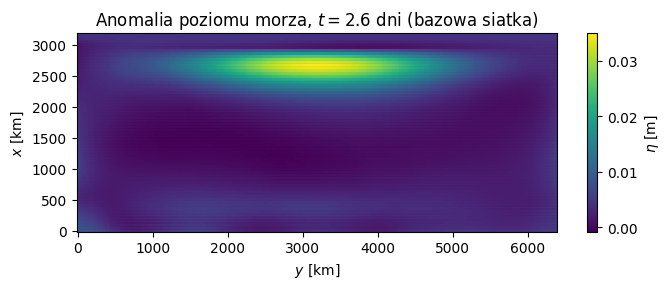

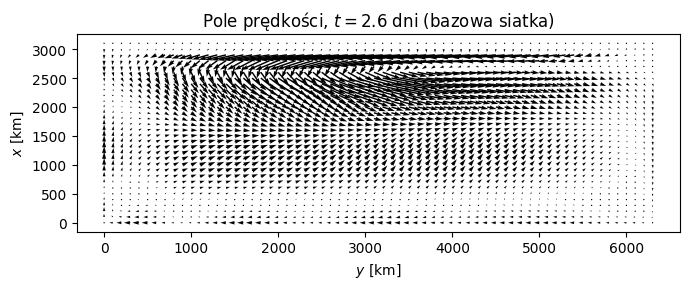

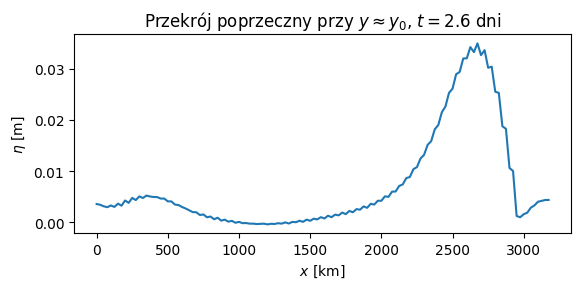

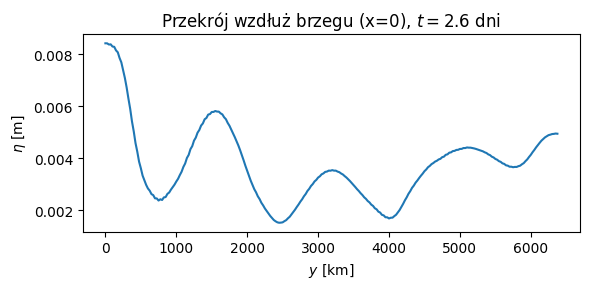

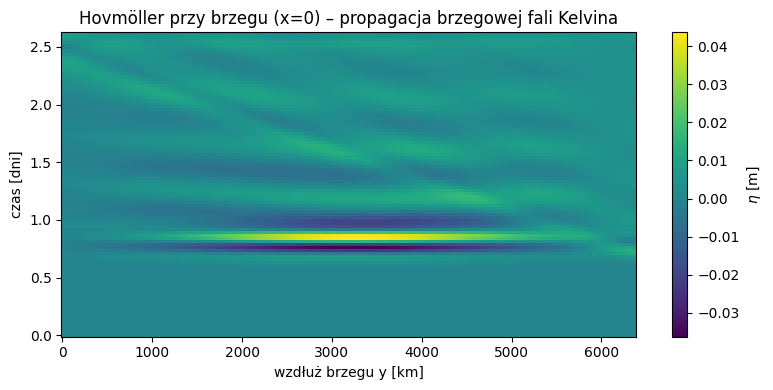

In [8]:
# np. bazowa siatka:
sim_base = run_kelvin_sim(nx0, ny0, dx0, dy0, CFL=CFL0, nt=nt0, outfreq=outfreq0)

plot_kelvin_fields(sim_base,
                   snapshot_index=-1,
                   label="bazowa siatka",
                   downsample=4,
                   save_prefix="kelvin_base")


In [ ]:
space_factors = [1, 2, 4]  # 1x, 2x, 4x gęstsza siatka
space_results = []

Lx_dom = nx0 * dx0
Ly_dom = ny0 * dy0

for f in space_factors:
    nx = nx0 * f
    ny = ny0 * f
    dx = Lx_dom / nx
    dy = Ly_dom / ny

    # chcemy ten sam czas fizyczny T_total
    dt = CFL0 * dx / c
    nt = int(T_total / dt)

    sim = run_kelvin_sim(
        nx=nx,
        ny=ny,
        dx=dx,
        dy=dy,
        CFL=CFL0,
        nt=nt,
        outfreq=outfreq0,
    )

    speed, times_traj, y_traj = compute_kelvin_speed(
        sim["output"]["h"], H_val, sim["dt"], sim["outfreq"], sim["dy"]
    )
    width = compute_cross_shore_width(
        sim["output"]["h"], H_val, sim["dx"], sim["y0_index"]
    )

    space_results.append({
        "factor_space": f,
        "nx": nx,
        "ny": ny,
        "dx": dx,
        "dy": dy,
        "L_R_over_dx": L_R / dx,
        "speed_num": speed,
        "speed_theory": c,
        "speed_ratio": speed / c,
        "width_sigma": width,
        "width_over_LR": width / L_R,
        "sim": sim,  # zachowujemy wszystko do późniejszej wizualizacji
    })

for r in space_results:
    print(
        f"f={r['factor_space']:>2d}  "
        f"L_R/dx={r['L_R_over_dx']:6.2f}  "
        f"c_num={r['speed_num']:6.3f} m/s  "
        f"c_num/c={r['speed_ratio']:6.3f}  "
        f"σ/L_R={r['width_over_LR']:6.3f}"
    )


In [ ]:
time_factors = [1, 2, 4]  # 1x, 2x, 4x lepsza rozdzielczość w czasie
time_results = []

for ft in time_factors:
    CFL = CFL0 / ft          # dt -> dt0 / ft
    dt = CFL * dx0 / c
    nt = int(T_total / dt)   # ten sam czas fizyczny

    sim = run_kelvin_sim(
        nx=nx0,
        ny=ny0,
        dx=dx0,
        dy=dy0,
        CFL=CFL,
        nt=nt,
        outfreq=outfreq0,
    )

    speed, times_traj, y_traj = compute_kelvin_speed(
        sim["output"]["h"], H_val, sim["dt"], sim["outfreq"], sim["dy"]
    )
    width = compute_cross_shore_width(
        sim["output"]["h"], H_val, sim["dx"], sim["y0_index"]
    )

    time_results.append({
        "factor_time": ft,
        "dt": sim["dt"],
        "nt": nt,
        "speed_num": speed,
        "speed_theory": c,
        "speed_ratio": speed / c,
        "width_sigma": width,
        "width_over_LR": width / L_R,
        "sim": sim,
    })

for r in time_results:
    print(
        f"ft={r['factor_time']:>2d}  "
        f"dt={r['dt']:7.1f} s  nt={r['nt']:6d}  "
        f"c_num={r['speed_num']:6.3f} m/s  "
        f"c_num/c={r['speed_ratio']:6.3f}  "
        f"σ/L_R={r['width_over_LR']:6.3f}"
    )


In [ ]:
def visualize_space_results(space_results, *, save_prefix: str | None = None):
    """
    Wizualizacja zależności wyników od rozdzielczości przestrzennej.

    space_results – lista słowników jak w Twoim kodzie:
      {
        "factor_space": f,
        "nx": nx,
        "ny": ny,
        "dx": dx,
        "dy": dy,
        "L_R_over_dx": L_R / dx,
        "speed_num": speed,
        "speed_theory": c,
        "speed_ratio": speed / c,
        "width_sigma": width,
        "width_over_LR": width / L_R,
        "sim": sim,
      }
    save_prefix – jeśli nie None, zapisze wykresy jako
      save_prefix + "_speed_vs_res.pdf"
      save_prefix + "_width_vs_res.pdf"
    """

    # --- zrzut danych do tablic ---
    L_over_dx   = np.array([r["L_R_over_dx"] for r in space_results])
    speed_ratio = np.array([r["speed_ratio"]   for r in space_results])
    width_ratio = np.array([r["width_over_LR"] for r in space_results])
    factors     = np.array([r["factor_space"]  for r in space_results])

    # sortowanie po L_R/dx (na wszelki wypadek)
    idx = np.argsort(L_over_dx)
    L_over_dx   = L_over_dx[idx]
    speed_ratio = speed_ratio[idx]
    width_ratio = width_ratio[idx]
    factors     = factors[idx]

    # === 1) c_num / c vs L_R / Δx ===
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(L_over_dx, speed_ratio, "o-", label=r"obliczenia numeryczne")
    ax1.axhline(1.0, color="gray", linestyle="--",
                label=r"wartość teoretyczna $c_\mathrm{num}/c = 1$")
    for Lval, rval, f in zip(L_over_dx, speed_ratio, factors):
        ax1.annotate(f"f={f}", (Lval, rval),
                     textcoords="offset points", xytext=(5, 5), fontsize=8)

    ax1.set_xlabel(r"$L_R / \Delta x$")
    ax1.set_ylabel(r"$c_\mathrm{num} / c$")
    ax1.set_title(r"Zależność prędkości propagacji od rozdzielczości siatki")
    ax1.grid(True, linestyle=":", alpha=0.5)
    ax1.legend()
    fig1.tight_layout()

    if save_prefix is not None:
        fig1.savefig(f"{save_prefix}_speed_vs_res.pdf")

    # plt.show()

    # === 2) σ / L_R vs L_R / Δx ===
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.plot(L_over_dx, width_ratio, "o-", label=r"obliczenia numeryczne")
    ax2.axhline(1.0, color="gray", linestyle="--",
                label=r"profil teoretyczny $\sigma / L_R \approx 1$")
    for Lval, rval, f in zip(L_over_dx, width_ratio, factors):
        ax2.annotate(f"f={f}", (Lval, rval),
                     textcoords="offset points", xytext=(5, 5), fontsize=8)

    ax2.set_xlabel(r"$L_R / \Delta x$")
    ax2.set_ylabel(r"$\sigma / L_R$")
    ax2.set_title(r"Szerokość poprzeczna fali a rozdzielczość siatki")
    ax2.grid(True, linestyle=":", alpha=0.5)
    ax2.legend()
    fig2.tight_layout()

    if save_prefix is not None:
        fig2.savefig(f"{save_prefix}_width_vs_res.pdf")

    # plt.show()


In [ ]:
def visualize_time_results(time_results, *, save_prefix: str | None = None):
    """
    Wizualizacja zależności wyników od rozdzielczości czasowej.

    time_results – lista słowników jak w Twoim kodzie:
      {
        "factor_time": ft,
        "dt": sim["dt"],
        "nt": nt,
        "speed_num": speed,
        "speed_theory": c,
        "speed_ratio": speed / c,
        "width_sigma": width,
        "width_over_LR": width / L_R,
        "sim": sim,
      }

    save_prefix – jeśli nie None, zapisze wykresy jako
      save_prefix + "_speed_vs_dt.pdf"
      save_prefix + "_width_vs_dt.pdf"
    """

    dt_arr       = np.array([r["dt"] for r in time_results])
    speed_ratio  = np.array([r["speed_ratio"]   for r in time_results])
    width_ratio  = np.array([r["width_over_LR"] for r in time_results])
    factors_time = np.array([r["factor_time"]   for r in time_results])

    # posortuj po dt (od największego do najmniejszego, albo odwrotnie – weźmy rosnąco)
    idx = np.argsort(dt_arr)
    dt_arr       = dt_arr[idx]
    speed_ratio  = speed_ratio[idx]
    width_ratio  = width_ratio[idx]
    factors_time = factors_time[idx]

    # === 1) c_num / c vs Δt ===
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(dt_arr, speed_ratio, "o-", label=r"obliczenia numeryczne")
    ax1.axhline(1.0, color="gray", linestyle="--",
                label=r"wartość teoretyczna $c_\mathrm{num}/c = 1$")

    for dt_val, r_val, ft in zip(dt_arr, speed_ratio, factors_time):
        ax1.annotate(f"ft={ft}", (dt_val, r_val),
                     textcoords="offset points", xytext=(5, 5), fontsize=8)

    ax1.set_xlabel(r"$\Delta t\ \mathrm{[s]}$")
    ax1.set_ylabel(r"$c_\mathrm{num} / c$")
    ax1.set_title(r"Zależność prędkości propagacji od kroku czasowego")
    ax1.grid(True, linestyle=":", alpha=0.5)
    ax1.legend()
    ax1.set_xscale("log")  # często sensowne przy zmianach o czynnik 2, 4, ...
    fig1.tight_layout()

    if save_prefix is not None:
        fig1.savefig(f"{save_prefix}_speed_vs_dt.pdf")

    # plt.show()

    # === 2) σ / L_R vs Δt ===
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.plot(dt_arr, width_ratio, "o-", label=r"obliczenia numeryczne")
    ax2.axhline(1.0, color="gray", linestyle="--",
                label=r"profil teoretyczny $\sigma / L_R \approx 1$")

    for dt_val, r_val, ft in zip(dt_arr, width_ratio, factors_time):
        ax2.annotate(f"ft={ft}", (dt_val, r_val),
                     textcoords="offset points", xytext=(5, 5), fontsize=8)

    ax2.set_xlabel(r"$\Delta t\ \mathrm{[s]}$")
    ax2.set_ylabel(r"$\sigma / L_R$")
    ax2.set_title(r"Szerokość poprzeczna fali a krok czasowy")
    ax2.grid(True, linestyle=":", alpha=0.5)
    ax2.legend()
    ax2.set_xscale("log")
    fig2.tight_layout()

    if save_prefix is not None:
        fig2.savefig(f"{save_prefix}_width_vs_dt.pdf")

    # plt.show()


**Zależność wyników od zwiększenia rozdzielczości przestrzennej**

In [ ]:
visualize_space_results(space_results, save_prefix="kelvin_space_convergence")
for r in space_results:
  plot_kelvin_fields(r["sim"],
                     snapshot_index=-1,
                     label=f"f={r['factor_space']}",
                     downsample=4,
                     save_prefix=f"kelvin_space_convergence_f{r['factor_space']}")


**Zależność wyników od zwiększenia rozdzielczości czasowej**

In [ ]:
visualize_time_results(time_results, save_prefix="kelvin_time_convergence")

## Wnioski

Na podstawie przeprowadzonych symulacji można stwierdzić, że:

1. Przy odpowiednio drobnej siatce $(\Delta x \ll R_d$)
   uzyskana fala przy brzegu zachowuje właściwości typowe dla
   brzegowej fali Kelvina:
   propaguje się wzdłuż brzegu w jednym kierunku, a amplituda
   zanika w głąb basenu z szerokością rzędu promienia Rossby'ego.

2. Siatka $\Delta x \sim R_d$ lub większa prowadzi
   do zniekształcenia zarówno prędkości propagacji, jak i profilu
   poprzecznego fali:
   efektywna szerokość fali rośnie, a prędkość odbiega od rozwiązania
   analitycznego.

### Odpowiedź na postawione pytanie

Tak, korzystając z równań dynamiki płynu w przybliżeniu „płytkiej wody”
można numerycznie odtworzyć brzegową falę Kelvina, pod warunkiem
zapewnienia odpowiedniej rozdzielczości siatki numerycznej względem
promienia deformacji Rossby’ego $R_d$.

Rozdzielczość siatki ma istotny wpływ na:

- **prędkość propagacji fali wzdłuż brzegu** – dla $\Delta x \ll R_d$
  prędkość jest zbliżona do wartości teoretycznej, natomiast dla
  $\Delta x \gtrsim R_d$ pojawiają się zauważalne odchylenia;
- **szerokość poprzeczną fali** – przy drobnej siatce profile poprzeczne
  zgadzają się z przewidywaniami teoretycznymi i mają szerokość rzędu
  $R_d$, natomiast przy zbyt dużym kroku siatki fala ulega
  „rozmyciu” i traci charakter typowy dla fali Kelvina.

Szczegółowe wartości liczbowych (prędkości i szerokości) należy
odczytać z przeprowadzonych symulacji dla poszczególnych konfiguracji
$\Delta x / R_d$.
